In [1]:
import matplotlib.pyplot as plt
import numpy as np
import json
import re

# Классификация текста по канонам

Соберём данные заново и помимо классификации сделаем визуализацию.
Класса будет два: Алкомодель и РИА новости; разница будет существенная.
Только на этот раз всё сделаем по гайду от sklearn:

http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html

In [2]:
from get_tweets import get_tweets
import csv

In [3]:
example_string = "@huabf Get Rid of those каРапузов !"
def purify(str):
    # delete all URLs
    str = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', str, flags=re.MULTILINE)
    #delete all usernames
    str = re.sub(r'@\w+', '', str)
    return str.lower()
print(purify(example_string))

 get rid of those карапузов !


In [4]:
accounts = ["alcomodel", "rianru"]
def generate_data(accounts):
    train_data = []
    for account in accounts:
        with open("unsorted/{0}_tweets.csv".format(account)) as fp:
            raw_data = csv.reader(fp, delimiter = '|')
            for line in raw_data:
                if line[0:1] != "RT":       #ignore retweets
                    train_data.append([purify(line[3]), account])
    train_target = [train_data[i][1] for i in range(len(train_data))]
    train_data = [train_data[i][0] for i in range(len(train_data))]
    return train_data, train_target
train_data, train_target = generate_data(accounts)
print(len(train_data))

399


In [5]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(train_data)
X_train_counts.shape

(399, 1956)

In [6]:
from sklearn.feature_extraction.text import TfidfTransformer
tf_transformer = TfidfTransformer()
X_train_tf = tf_transformer.fit_transform(X_train_counts)
X_train_tf.shape

(399, 1956)

In [7]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_tf, train_target)

Теперь можно заставить классификатор предсказывать

In [8]:
def predict(str, clf):
    X_new_counts = count_vect.transform(str)
    X_new_tfidf = tf_transformer.transform(X_new_counts)
    
    predicted = clf.predict(X_new_tfidf)
    
    for doc, category in zip(str, predicted):   
        print("%r => %s" % (doc, category))

In [9]:
test_data = []
test_data.append("Ладно, допустим, лёд между нами уже растаял, А ЖИР-ТО МОЙ КОГДА НАЧНЁТ ТАЯТЬ???!!! Или это не так работает?")
test_data.append("Меня чуть не сбил велосипедист на пешеходном переходе. Ладно. Хорошо.")
test_data.append("Премьер Франции заявил, что Ферран останется в кабмине, несмотря на скандал")

In [10]:
print(predict(test_data, clf))

'Ладно, допустим, лёд между нами уже растаял, А ЖИР-ТО МОЙ КОГДА НАЧНЁТ ТАЯТЬ???!!! Или это не так работает?' => alcomodel
'Меня чуть не сбил велосипедист на пешеходном переходе. Ладно. Хорошо.' => alcomodel
'Премьер Франции заявил, что Ферран останется в кабмине, несмотря на скандал' => rianru
None


# Попытка визуализации

In [11]:
print(X_train_counts.toarray()[0:199].shape[0])

199


In [12]:
X1 = np.sum(X_train_tf.toarray()[0:199], axis=0)
X2 = np.sum(X_train_tf.toarray()[200:399], axis=0)
print(len(X1), len(X2))

1956 1956


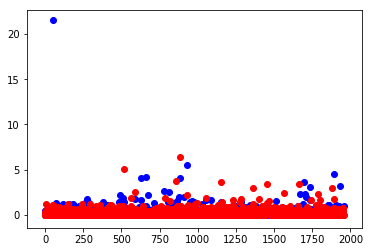

In [13]:
plt.figure()
plt.scatter(range(len(X1)), X1, color = "blue")
plt.scatter(range(len(X2)), X2, color = "red")
plt.show()

# Обучение на всех имеющихся классах

Для начала превратим все имеющиеся у нас данные в один документ с форматом ["класс", "твит"]

Вариант для собранных данных. 
P.S. Вариант для сбора данных уже есть в collect data.ipynb

In [14]:
import os

In [15]:
train_data = []
for cat in os.listdir("classes"):
    if cat[0] != '.':
        for account in os.listdir("classes/%s" % cat):
            with open("classes/%s/%s" % (cat, account)) as fp:
                raw_data = csv.reader(fp, delimiter = '|')
                for line in raw_data:
                    if line[0:1] != "RT":    # ignore retweets
                        train_data.append([str(purify(line[3])), cat])
train_target = [train_data[i][1] for i in range(len(train_data))]

In [16]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform([train_data[i][0] for i in range(len(train_data))])
X_train_counts.shape

(26993, 53973)

In [17]:
from sklearn.feature_extraction.text import TfidfTransformer
tf_transformer = TfidfTransformer()
X_train_tf = tf_transformer.fit_transform(X_train_counts)
X_train_tf.shape

(26993, 53973)

In [18]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_tf, train_target)

In [19]:
def predict(arr, clf):
    X_new_counts = count_vect.transform(arr)
    X_new_tfidf = tf_transformer.transform(X_new_counts)
    
    predicted = clf.predict(X_new_tfidf)
    
    for doc, category in zip(arr, predicted):   
        print("%r => %s" % (doc, category))

In [20]:
def test_perfomance(test_data, clf=clf):
    data = [test_data[i][0] for i in range(len(test_data))]
    target = [test_data[i][1] for i in range(len(test_data))]
    X_new_counts = count_vect.transform(data)
    X_new_tfidf = tf_transformer.transform(X_new_counts)

    predicted = clf.predict(X_new_tfidf)
    
    counter_total = 0
    counter_correct = 0
    for doc, category, tar in zip(data, predicted, target):
        counter_total += 1
        if category == tar:
            counter_correct += 1
    print("Всего: %s, Правильно: %s" % (counter_total, counter_correct))
    print("Вероятность правильного определения: %.2f%%" % (counter_correct/counter_total*100), )

In [21]:
test_perfomance(train_data, clf)

Всего: 26993, Правильно: 22499
Вероятность правильного определения: 83.35%


Построим Pipeline, таким образом объединим токенизацию, векторизацию и функцию весов в одну функцию.

from sklearn.pipeline import Pipeline
text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB()),
])
data = [train_data[i][0] for i in range(len(train_data))]
target = [train_data[i][1] for i in range(len(train_data))]
text_clf.fit(data, target)

In [22]:
from sklearn.linear_model import SGDClassifier
svm_clf = SGDClassifier(loss = 'perceptron', n_iter=10)
svm_clf.fit(X_train_tf, train_target)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='perceptron', n_iter=10, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)

predicted = text_clf.predict(train_data)
np.mean(predicted == train_arget) 

In [23]:
test_perfomance(train_data, svm_clf)

Всего: 26993, Правильно: 26278
Вероятность правильного определения: 97.35%


# Опреление пола пользователя

Имеется массив данных с бинарным разделением признаков: пользователь мужчина и пользователь женщина.
Попробуем из этих данных узнать пол пользователя

In [24]:
gender_data = []
for cat in os.listdir("gender"):
    if cat[0] != '.':
        for account in os.listdir("gender/%s" % cat):
            with open("gender/%s/%s" % (cat, account)) as fp:
                raw_data = csv.reader(fp, delimiter = '|')
                for line in raw_data:
                    if line[0:1] != "RT":    # ignore retweets
                        gender_data.append([purify(line[3]), cat])
gender_target = [gender_data[i][1] for i in range(len(gender_data))]

In [25]:
print(gender_data[4][0])

rt : si este tweet llega a 1000rts voy vestida d canguro a selectividad (y mis amigos m harán un súper regalo) #popolomenotovivo #po…


In [26]:
from sklearn.pipeline import Pipeline
gender_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', SGDClassifier(loss='perceptron', penalty='l2',
                                           alpha=1e-3, n_iter=5, random_state=42)),
])

In [27]:
text_gender = [str(gender_data[i][0]) for i in range(len(gender_data))]
print(str(text_gender[0]))

извините 


In [28]:
gender_clf = gender_clf.fit(text_gender, gender_target)

In [29]:
predicted = gender_clf.predict(text_gender)
np.mean(predicted == gender_target)

0.95114837768866201

# Получение результатов

In [30]:
from get_tweets import get_tweets

Теперь необходимо сделать вывод полученной информации для выбранного пользователем акканута твиттер

In [31]:
import matplotlib.pyplot as plt
from collections import Counter
import tweepy
import config

auth = tweepy.OAuthHandler(config.consumer_key, config.consumer_secret)
auth.set_access_token(config.access_key, config.access_secret)

api = tweepy.API(auth)

def classify(username):
    get_tweets(username, folder = "unsorted")
    tweets = []
    with open("unsorted/{0}_tweets.csv".format(username)) as fp:
        raw_data = csv.reader(fp, delimiter = '|')
        for line in raw_data:
            if line[0:1] != "RT":       #ignore retweets
                tweets.append(purify(line[3]))
    #tweets are ready
    X_new_counts = count_vect.transform(tweets)
    X_new_tfidf = tf_transformer.transform(X_new_counts)
    
    predicted = clf.predict(X_new_tfidf)
    result = []
    for doc, category in zip(tweets, predicted):
        result.append(category)
    z = Counter(result)
    
    print("\n")
    user = api.get_user(username)

    print(user.name, ", ", user.followers_count, "подписчиков.")
    print("Интересы: ")
    
    labels = list(z)
    values = list(z.values())
    explode = [np.log(x)/50 for x in values]
    
    plt.pie(values, labels = labels, explode = explode,
        autopct='%1.1f%%', shadow=True, startangle=140)
 
    plt.axis('equal')
    plt.show()
    
    for value, label in zip(values, labels):
        print(label, " : %1.1f%%" % (value/len(tweets)*100))
        
    gender_predict = gender_clf.predict(tweets)
    gender_result=[]
    for doc, category in zip(tweets, gender_predict):
        gender_result.append(category)
    print("Gender: ", Counter(gender_result).most_common()[0][0])

writing to unsorted/brupsen_tweets.csv


Брусничный ,  35 подписчиков.
Интересы: 


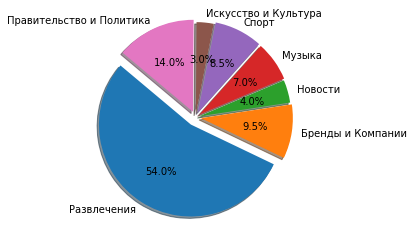

Развлечения  : 54.0%
Бренды и Компании  : 9.5%
Новости  : 4.0%
Музыка  : 7.0%
Спорт  : 8.5%
Искусство и Культура  : 3.0%
Правительство и Политика  : 14.0%
Gender:  Мужчина


In [32]:
classify("brupsen")

writing to unsorted/medvedevrussia_tweets.csv


Дмитрий Медведев ,  5524369 подписчиков.
Интересы: 


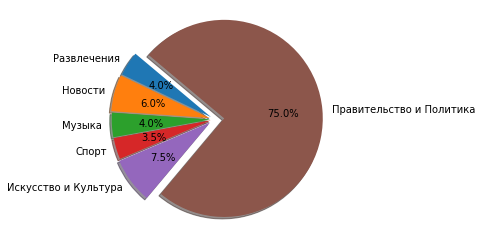

Развлечения  : 4.0%
Новости  : 6.0%
Музыка  : 4.0%
Спорт  : 3.5%
Искусство и Культура  : 7.5%
Правительство и Политика  : 75.0%
Gender:  Женщина


In [33]:
classify("medvedevrussia")

writing to unsorted/kinamanka_tweets.csv


Rick ,  23 подписчиков.
Интересы: 


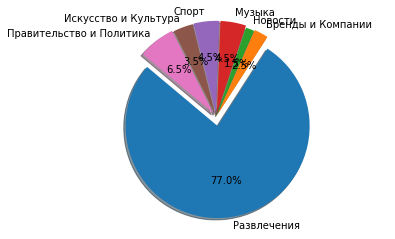

Развлечения  : 77.0%
Бренды и Компании  : 2.5%
Новости  : 1.5%
Музыка  : 4.5%
Спорт  : 4.5%
Искусство и Культура  : 3.5%
Правительство и Политика  : 6.5%
Gender:  Женщина


In [34]:
classify("kinamanka")

In [ ]:
!python3 classify.py

In [ ]:
from sklearn.externals import joblib
import matplotlib.pyplot as plt
from collections import Counter
import tweepy
import config
import csv
import sys
from get_tweets import get_tweets
from learn import purify
import numpy as np

auth = tweepy.OAuthHandler(config.consumer_key, config.consumer_secret)
auth.set_access_token(config.access_key, config.access_secret)
api = tweepy.API(auth)

def classify(username):
    if len(sys.argv) == 2:
        username = sys.argv[1]
    try:
        text_clf = joblib.load("models/text_model.pkl")
        gender_clf = joblib.load("models/gender_model.pkl")
    except FileNotFoundError:
        sys.exit("Не найден файл модели")
    get_tweets(username, folder="unsorted")
    tweets = []
    with open("unsorted/{0}_tweets.csv".format(username)) as fp:
        raw_data = csv.reader(fp, delimiter='|')
        for line in raw_data:
            if line[0:1] != "RT":  # ignore retweets
                tweets.append(purify(line[3]))

    predicted = text_clf.predict(tweets)
    result = []
    for doc, category in zip(tweets, predicted):
        result.append(category)
    z = Counter(result)
    user = api.get_user(username)
    labels = list(z)
    values = list(z.values())
    explode = [np.log(x) / 50 for x in values]

    plt.pie(values, labels=labels, explode=explode,
            autopct='%1.1f%%', shadow=True, startangle=140)
    plt.axis('equal')

    print("\n")
    print(user.name, ", ", user.followers_count, "подписчиков.")
    print("Интересы: ")

    for value, label in zip(values, labels):
        print(label, " : %1.1f%%" % (value / len(tweets) * 100))

    gender_predict = gender_clf.predict(tweets)
    gender_result = []
    for doc, category in zip(tweets, gender_predict):
        gender_result.append(category)
    print("Пол: ", Counter(gender_result).most_common()[0][0])
    plt.show()

writing to unsorted/medvedevrussia_tweets.csv


Дмитрий Медведев ,  5524446 подписчиков.
Интересы: 


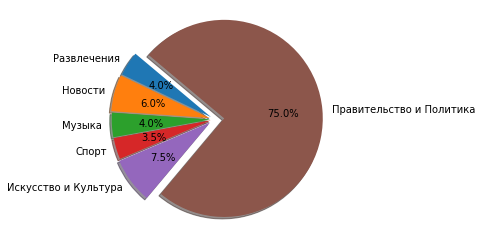

Развлечения  : 4.0%
Новости  : 6.0%
Музыка  : 4.0%
Спорт  : 3.5%
Искусство и Культура  : 7.5%
Правительство и Политика  : 75.0%
Gender:  Женщина


In [37]:
classify("medvedevrussia")

writing to unsorted/Stalingulag_tweets.csv


Сталингулаг ,  611084 подписчиков.
Интересы: 


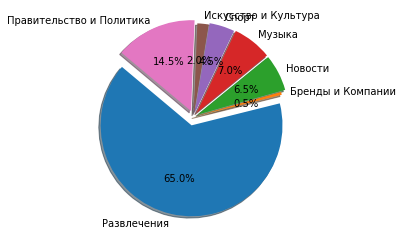

Развлечения  : 65.0%
Бренды и Компании  : 0.5%
Новости  : 6.5%
Музыка  : 7.0%
Спорт  : 4.5%
Искусство и Культура  : 2.0%
Правительство и Политика  : 14.5%
Gender:  Женщина


In [38]:
classify("Stalingulag")

writing to unsorted/mudakoff_tweets.csv


#MDK ,  181125 подписчиков.
Интересы: 


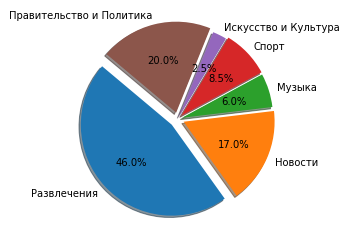

Развлечения  : 46.0%
Новости  : 17.0%
Музыка  : 6.0%
Спорт  : 8.5%
Искусство и Культура  : 2.5%
Правительство и Политика  : 20.0%
Gender:  Мужчина


In [39]:
classify("mudakoff")

writing to unsorted/navalny_tweets.csv


Alexey Navalny ,  1988986 подписчиков.
Интересы: 


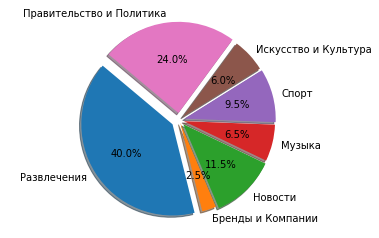

Развлечения  : 40.0%
Бренды и Компании  : 2.5%
Новости  : 11.5%
Музыка  : 6.5%
Спорт  : 9.5%
Искусство и Культура  : 6.0%
Правительство и Политика  : 24.0%
Gender:  Женщина


In [40]:
classify("navalny")

writing to unsorted/meduzaproject_tweets.csv


Meduza ,  1028070 подписчиков.
Интересы: 


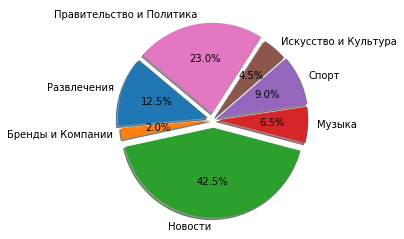

Развлечения  : 12.5%
Бренды и Компании  : 2.0%
Новости  : 42.5%
Музыка  : 6.5%
Спорт  : 9.0%
Искусство и Культура  : 4.5%
Правительство и Политика  : 23.0%
Gender:  Мужчина


In [41]:
classify("meduzaproject")

writing to unsorted/rianru_tweets.csv


РИА Новости ,  3176562 подписчиков.
Интересы: 


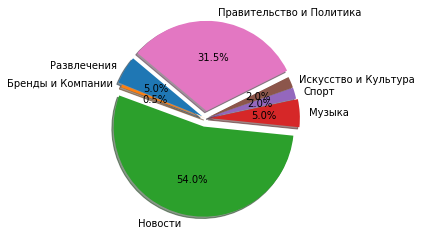

Развлечения  : 5.0%
Бренды и Компании  : 0.5%
Новости  : 54.0%
Музыка  : 5.0%
Спорт  : 2.0%
Искусство и Культура  : 2.0%
Правительство и Политика  : 31.5%
Gender:  Женщина


In [42]:
classify("rianru")

writing to unsorted/whysodisgusting_tweets.csv


Лёша ,  296 подписчиков.
Интересы: 


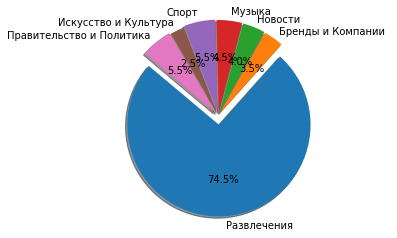

Развлечения  : 74.5%
Бренды и Компании  : 3.5%
Новости  : 4.0%
Музыка  : 4.5%
Спорт  : 5.5%
Искусство и Культура  : 2.5%
Правительство и Политика  : 5.5%
Gender:  Мужчина


In [43]:
classify("whysodisgusting")

writing to unsorted/alcomodel_tweets.csv


у тебя такой большой ,  6433 подписчиков.
Интересы: 


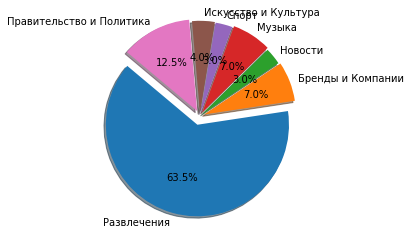

Развлечения  : 63.5%
Бренды и Компании  : 7.0%
Новости  : 3.0%
Музыка  : 7.0%
Спорт  : 3.0%
Искусство и Культура  : 4.0%
Правительство и Политика  : 12.5%
Gender:  Женщина


In [44]:
classify("alcomodel")

writing to unsorted/Narisovana_ka_tweets.csv


Картина Сучка ,  242 подписчиков.
Интересы: 


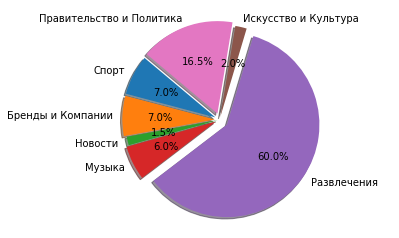

Спорт  : 7.0%
Бренды и Компании  : 7.0%
Новости  : 1.5%
Музыка  : 6.0%
Развлечения  : 60.0%
Искусство и Культура  : 2.0%
Правительство и Политика  : 16.5%
Gender:  Женщина


In [45]:
classify("Narisovana_ka")